# Boostrapping error metrics for SAMPL5

What's here is copied from Niel's `Boot8` directory on Kirkwood. I am adding new plots to the code but not changing any of the underlying calculations.

First, let's add `seaborn` to the list of imports

In [374]:
import sys,re
import numpy as np
from scipy import stats
import matplotlib as mpl 
# mpl.use('agg')
%matplotlib inline  
import matplotlib.pyplot as plt

import seaborn as sns
import panas as pd
import os

## Definitions and settings

Since I'm running this interatively, I'm going to specify the `arg` array here and then loop through `args` instead of `sys.argv` below.

In [375]:
# os.chdir("Calc-OA")
# args = ["ka", "../Exp/OASaltDep.txt", "APR-OPC.txt", "APR-TIP3P.txt", 
#         "BEDAM.txt", "CCSD(T)-neutral.txt", "DFT-charged.txt", "DFT-neutral.txt",
#         "Metadynamics.txt", "MMPBSA-GAFF.txt", "MovTyp-1.txt", "MovTyp-2.txt",
#         "PERT-bound-c.txt", "PERT-bound.txt", "PERT-hrex-c1.txt", "PERT-hrex-c2.txt",
#         "PERT-hrex-c.txt", "PERT-hrex.txt", "SOMD-1.txt", "SOMD-2.txt", "SOMD-3.txt",
#         "SOMD-4.txt", "Null.txt", "Null2.txt"]

#SaltDep-Abs
os.chdir('/run/media/dslochower/b52b33d4-b9b5-4e58-a87e-d8751720538c/2016-Research/Nonequilibrium/torsion-individual/Boot8/Calc-OA')
string = 'ka ../Exp/OASaltDep.txt Null1.txt Null2.txt APR-OPC.txt APR-TIP3P.txt BEDAM.txt Metadynamics.txt MMPBSA-GAFF.txt MovTyp-1.txt MovTyp-2.txt PERT-bound-c.txt PERT-bound.txt PERT-hrex-c1.txt PERT-hrex-c2.txt PERT-hrex-c.txt PERT-hrex.txt SOMD-1.txt SOMD-2.txt SOMD-3.txt SOMD-4.txt'
args = string.split()


In [376]:
OAHOnly = False
OAMeOnly = False
CalcPairDiffs = False
CorrectOA = False
CorrectCB = False
WithUncert = True 
WithRep = True  

### Arguments: <Flags> <ExpType> <ExperimentFile> <CalculationFile1> [<CalculationFile2> ...]
### Note, files should have the same number of data points
calcfiles=[]
for arg in args:
  if arg == 'OAHOnly':
    OAHOnly = True
  if arg == 'OAMeOnly':
    OAMeOnly = True
  if arg == 'CalcPairDiffs':
    CalcPairDiffs = True
  if arg == 'CorrectOA':
    CorrectOA = True
  if arg == 'CorrectCB':
    CorrectCB = True
  if re.search(r'^(ka|dg|dh)$', arg):
    exptype = arg
  if re.search(r'\.txt$', arg):
    if re.search(r'Exp', arg):
      expfile = arg
    else:
      calcfiles.append(arg)


### Settings
R = 0.0019872036
T = 298.0
BootCyc = 100
MNames = ('Slope', 'Interc', 'R', 'R^2', 'RMSE', 'MSE', 'MUE', 'TAU')
Nm = len(MNames)

In [377]:
### Error Metric Calculations
def geterrormetrics(x, y):
  MTmp = np.zeros([Nm], np.float64)
  # Slope, Intercept, R
  Slp, MTmp[1], MTmp[2], pval, stderr = stats.linregress(x,y)
  MTmp[0] = np.abs(1-Slp)
  # R^2
  MTmp[3] = MTmp[2]**2
  # RMSE
  MTmp[4] = np.sqrt(np.mean(((y - x)**2)))
  # MSE
  MTmp[5] = np.mean((y - x))
  # MUE
  MTmp[6] = np.mean(np.absolute(y - x))
  # Tau
  MTmp[7], prob = stats.kendalltau(x,y)
  return (MTmp)


### BootStrapping Definition
def bootstrap(x, xsem, y, ysem):
  MBoot = np.zeros([Nm,BootCyc], np.float64)
  MVals = np.zeros([Nm], np.float64)
  MSEMs = np.zeros([Nm], np.float64)
  xtmp = np.zeros([len(x)], np.float64)
  ytmp = np.zeros([len(x)], np.float64)
  yfit = np.zeros([len(x)], np.float64)

  for b in range(BootCyc):
    for i in range(len(x)):

      # Sample with/without replacement?
      if WithRep:
        j = np.random.randint(len(x))
      else:
        j = i

      # Sampling Statistical Uncertainty
      if not WithUncert or xsem[j] == 0.0:
        xtmp[i] = x[j]
      else:
        xtmp[i] = np.random.normal(x[j],xsem[j])
      if not WithUncert or ysem[j] == 0.0:
        ytmp[i] = y[j]
      else:
        ytmp[i] = np.random.normal(y[j],ysem[j])

      MBoot[0:Nm,b] = geterrormetrics(xtmp, ytmp)
  
  for m in range(Nm):
    MVals[m]=np.mean(MBoot[m])
    MSEMs[m]=np.std(MBoot[m])

  return (MVals,MSEMs,MBoot)

## Load in data nd do the calculation

In [378]:
### Load experimental file and place data in array
print(expfile)
with open(expfile, 'r') as expraw:
  explines = expraw.readlines()
exp = []
for line in explines:
  if not re.match(r'^\s*$', line):
    exp.append(line.rstrip().replace('\t', ' '))

### If "Only" flag, just do first six, or last six
if OAHOnly:
  exp = exp[0:6]
if OAMeOnly:
  exp = exp[6:12]
if OAHOnly and OAMeOnly:
  print("OAHOnly=True and OAMeOnly=True! Not compatible")
  exit()
N = len(exp)	# Number of data points
Np = (N-1)*N/2  # Number of data pairs

### Are these binding constants or free energy (or enthalpy)? Convert.
emean = np.zeros([N], np.float64)
esem = np.zeros([N], np.float64)
for i in range(len(exp)):
  cols = np.asarray(exp[i].split(), dtype=np.float64)
  if exptype == 'ka':       ### Assume binding constant. This could go wrong for very positive enthalpy
    dG = -R*T*np.log(cols)
    emean[i] = np.mean(dG)
    esem[i] = np.std(dG, ddof=1)/np.sqrt(len(dG))
  elif exptype == 'dg':
    emean[i] = cols[0]
    esem[i] = cols[1]
  elif exptype == 'dh': 
    emean[i] = np.mean(cols)/1000
    esem[i] = np.std(cols, ddof=1)/np.sqrt(len(cols))/1000
  else:
    print(exptype, "... is not a valid experimental type")

### Calculate Experimental Pairwise Differences
if CalcPairDiffs:
  h = 0
  epmean = np.zeros([Np], np.float64)
  epsem = np.zeros([Np], np.float64)
  for i in range(len(exp)):
    for j in range(i+1, len(exp)):
      epmean[h] = emean[i] - emean[j]
      epsem[h] = np.sqrt( esem[i]**2 + esem[j]**2 )
      h += 1

### Read in Calculated data.  
### I should add a check to make sure number of data points is the same as experiment
Nc = len(calcfiles)
cmean = np.zeros([Nc,N], np.float64)
csem = np.zeros([Nc,N], np.float64)
if CalcPairDiffs:
  cdmean = np.zeros([Nc,Nd], np.float64)
  cdsem = np.zeros([Nc,Nd], np.float64)

RawMs = np.zeros([Nc,Nm], np.float64)
AllMBoot = np.zeros([Nc,Nm,BootCyc], np.float64)
AllMVals = np.zeros([Nc,Nm], np.float64)
AllMSEMs = np.zeros([Nc,Nm], np.float64)

### Print Metrics Column Headings
#print "%30s " % ("Submission"),
#for Name in MNames:
#  print "%6s " % (Name),
#print ""

nc = 0
for calcfile in calcfiles:
  calc = np.loadtxt(calcfile, np.float64)
  if OAHOnly:
    calc = calc[0:6]
  if OAMeOnly:
    calc = calc[6:12]
  for i in range(len(calc)):
    if np.isscalar(calc[i]) == True:      ### If scalar instead of array; ie, no SEM given.
      cmean[nc,i] = np.mean(calc[i])
      csem[nc,i] = 0.0
    else:                                 ### Assume Mean and SEM given
      cmean[nc,i] = calc[i,0]
      csem[nc,i] = calc[i,1]
    #print emean[i],esem[i],tmpcmean[i],tmpcsem[i]


  ### Correct data set with MSE
  if CorrectOA:
    cmean[nc,0:6] = cmean[nc,0:6] - (np.mean(cmean[nc,0:6]) - np.mean(emean[0:6]))
    if len(calc) == 12:
      cmean[nc,6:12] = cmean[nc,6:12]- (np.mean(cmean[nc,6:12]) - np.mean(emean[6:12]))
  if CorrectCB:
    cmean[nc,0:10] = cmean[nc,0:10] - (np.mean(cmean[nc,0:10]) - np.mean(emean[0:10]))

  if CalcPairDiffs:
    h = 0
    for i in range(len(calc)):
      for j in range(i+1, len(calc)):
        cpmean[nc,h] = cmean[nc,i] - cmean[nc,j]
        cpsem[nc,h] = np.sqrt( csem[nc,i]**2 + csem[nc,j]**2 )
        #print cpmean[nc,h]#,cdsem[nc,h]
        h += 1

  RawMs[nc] = geterrormetrics(emean, cmean[nc])
  AllMVals[nc],AllMSEMs[nc],AllMBoot[nc] = bootstrap(emean, esem, cmean[nc], csem[nc])
  #print "%30s " % (calcfile),
  #for m in range(Nm):
  #  print "%6.2f " % (RawMs[nc,m]),
  #print ""
  
  nc += 1

../Exp/OASaltDep.txt


## Do the plotting

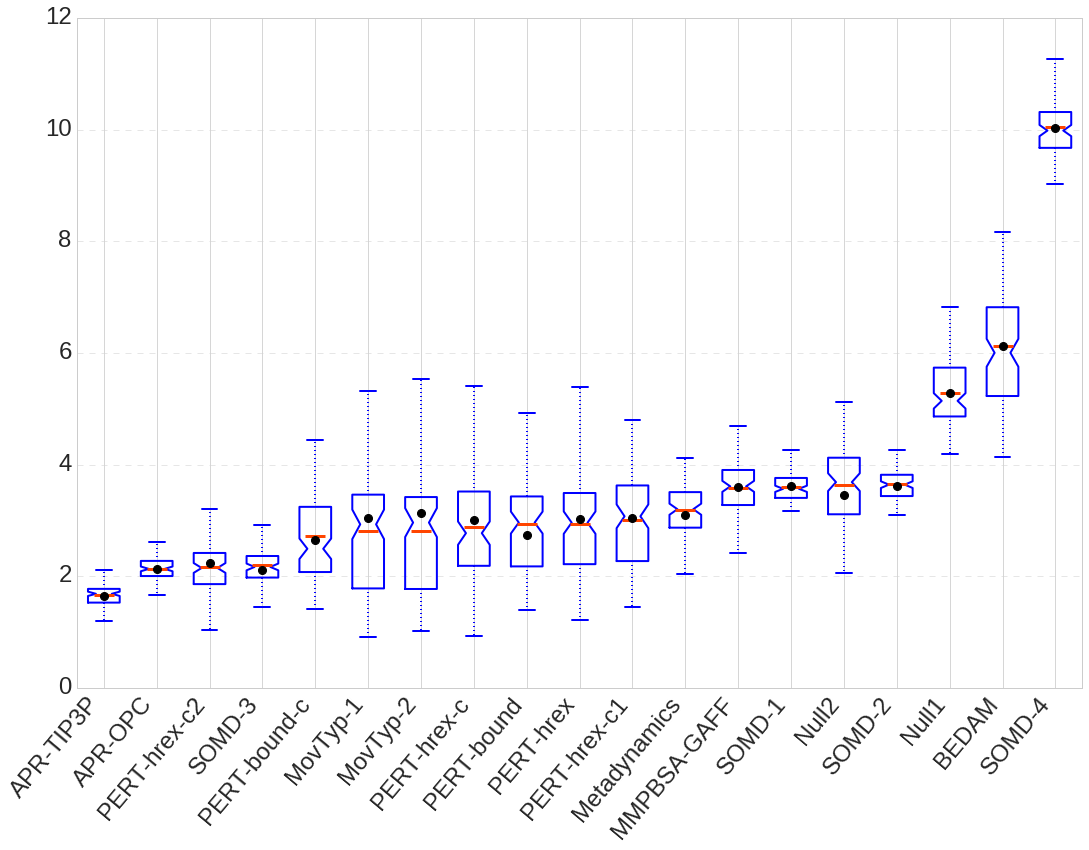

In [379]:
CalcNames=[]
for name in calcfiles:
  cols = name.split('.')
  CalcNames.append(cols[0])
  
Order = np.argsort(AllMVals[0:Nc,4])

Locs = np.arange(Nc)+1
plt.figure(1, figsize=(18,12), dpi=300)
plot2 = plt.boxplot([AllMBoot[nc,4] for nc in Order], widths=0.6, notch=True, sym='', positions=Locs)
ax = plt.axes()
ax.yaxis.grid(linestyle='--', which='major', color='lightgrey', alpha=0.7, zorder=0)
plt.setp(plot2['boxes'], color='b', linewidth=2.0) #,  facecolor='DarkMagenta')
plt.setp(plot2['whiskers'], color='b', linewidth=2.0, linestyle=':' )
plt.setp(plot2['caps'], color='b', linewidth=2.0)
plt.setp(plot2['medians'], color='None', linewidth=2.0)
plt.plot(Locs, [AllMVals[nc,4] for nc in Order], '_', color='OrangeRed', markersize=20, markeredgecolor='OrangeRed', markeredgewidth=3)
plt.plot(Locs, [RawMs[nc,4] for nc in Order], 'ko', markersize=8, markeredgecolor='k', markeredgewidth=1)
plt.xticks(Locs, [CalcNames[nc] for nc in Order], rotation=50, ha='right')
plt.show()
# plt.savefig('tmp.png')

# First, read in the data to a `pandas` DataFrame()

Because it was easiest to develop this way, I'm doing one DataFrame() at a time for each of the metrics above.

In [380]:
df = pd.DataFrame()
df['AllMBoot'] = np.hstack(([AllMBoot[n,4] for n in Order]))
df['Method'] = np.hstack(([np.repeat(CalcNames[n], len(AllMBoot[n,4]) ) for n in Order]))
df.head()

,AllMBoot,Method
0,1.544171,APR-TIP3P
1,1.621705,APR-TIP3P
2,1.555440,APR-TIP3P
3,1.726912,APR-TIP3P
4,1.931010,APR-TIP3P


This colors the violins black unless they are the null models.

In [381]:
labels = [CalcNames[n] for n in Order]
palette = ['k' if i != 'Null' and i != 'Null2' else 'r' for i in labels]

In [382]:
df2 = pd.DataFrame()
df2['RawMs'] = [RawMs[n,4] for n in Order]
df2['Method'] = [CalcNames[n] for n in Order]
df2.head()

,RawMs,Method
0,1.646412,APR-TIP3P
1,2.125403,APR-OPC
2,2.235458,PERT-hrex-c2
3,2.103726,SOMD-3
4,2.651054,PERT-bound-c


In [383]:
df3 = pd.DataFrame()
df3['AllMVals'] = [AllMVals[n,4] for n in Order]
df3['Method'] = [CalcNames[n] for n in Order]
df3.head()

,AllMVals,Method
0,1.656460,APR-TIP3P
1,2.131892,APR-OPC
2,2.167186,PERT-hrex-c2
3,2.191408,SOMD-3
4,2.719057,PERT-bound-c


In [384]:
df4 = pd.DataFrame()
df5 = pd.DataFrame()
df4['Value'] = [AllMVals[n,4] for n in Order]
df4['ValueMethod'] = ['AllMVals' for _ in Order] 
df4['Method'] = [CalcNames[n] for n in Order]
df5['Value'] = [RawMs[n,4] for n in Order]
df5['ValueMethod'] = ['RawMs' for _ in Order] 
df5['Method'] = [CalcNames[n] for n in Order]

frames = [df4, df5]
result = pd.concat(frames)
result.head()

,Value,ValueMethod,Method
0,1.656460,AllMVals,APR-TIP3P
1,2.131892,AllMVals,APR-OPC
2,2.167186,AllMVals,PERT-hrex-c2
3,2.191408,AllMVals,SOMD-3
4,2.719057,AllMVals,PERT-bound-c


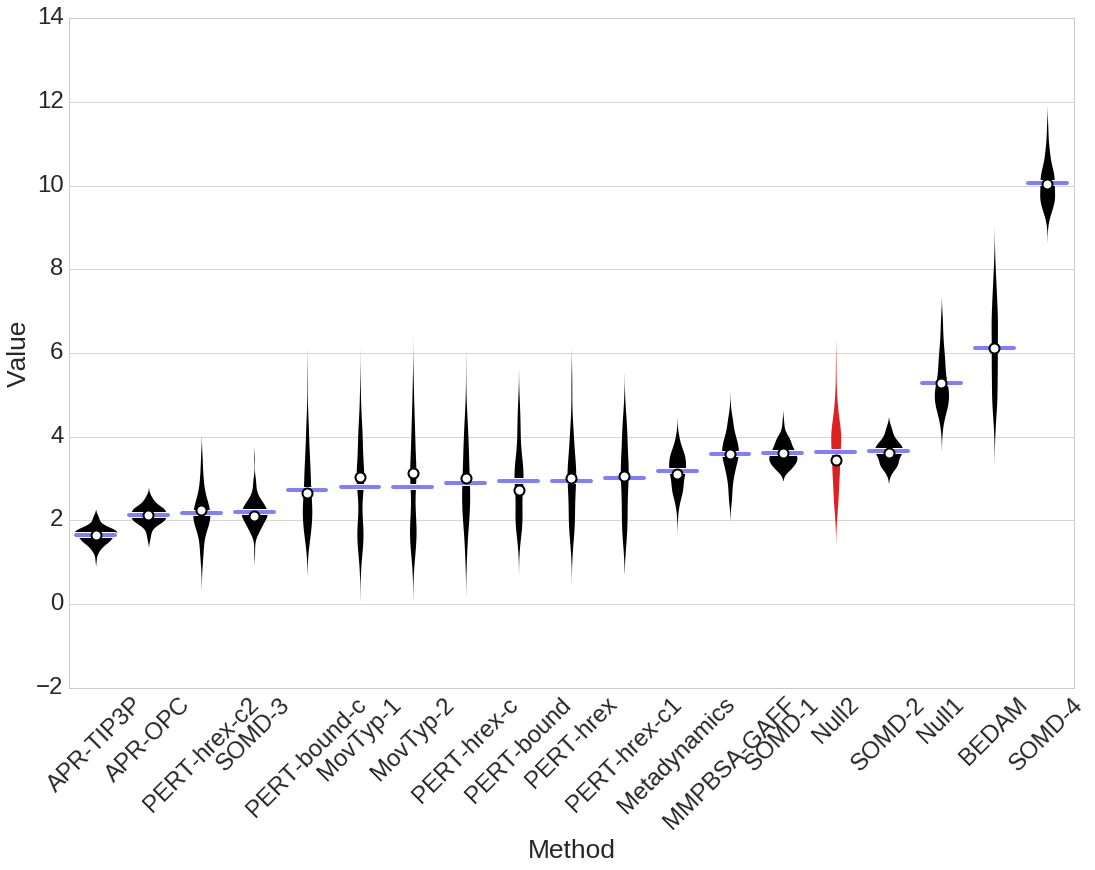

In [385]:
fig, ax = plt.subplots(1, figsize=(18,12), dpi=300)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")
sns.violinplot(x = 'Method', y = 'AllMBoot', data=df, inner=None, linewidth=0, palette=palette)
# Seaborn is a bit limiting here; some properties don't get passed through to matplotlib.
# sns.stripplot(x = 'Method', y = 'RawMs', data = df2, marker = 'o', color = 'w', zorder=21, edgecolor='black', s=10)
for n in Order:
    ax.scatter(x = np.where(Order == n)[0], y = df2[df2['Method'] == CalcNames[n]]['RawMs'], s = 100, marker = 'o', color = 'w', edgecolor = 'k', linewidth = 2, zorder = 21)
for n in Order:
    # This gets the column position because we are plotting using `Order` and the width of the line is 1/len(CalcNames).
    # We could shorten the line a little bit for better readability.
    ax.axhline(y = AllMVals[n, 4], xmin = (np.where(Order == n)[0] / len(CalcNames)) + 0.007, xmax = np.where(Order == n)[0] / len(CalcNames) + 1/len(CalcNames) - 0.007, linewidth=2, c='b', lw = 4, zorder=20, alpha=0.5)
    # This adds a bit of a white background around the lines by plotting underneath a slightly larger line.
    ax.axhline(y = AllMVals[n, 4], xmin = (np.where(Order == n)[0] / len(CalcNames)) + 0.007, xmax = np.where(Order == n)[0] / len(CalcNames) + 1/len(CalcNames) - 0.007, linewidth=2, c='w', lw = 6, zorder=19, alpha=1.0)
plt.xticks(rotation=45)
plt.ylabel('Value')

## Now let's try to loop over all four error metrics. We will have to deal with sorting Tau and R**2 separately.

In [386]:
np.shape(AllMBoot)

(19, 8, 100)

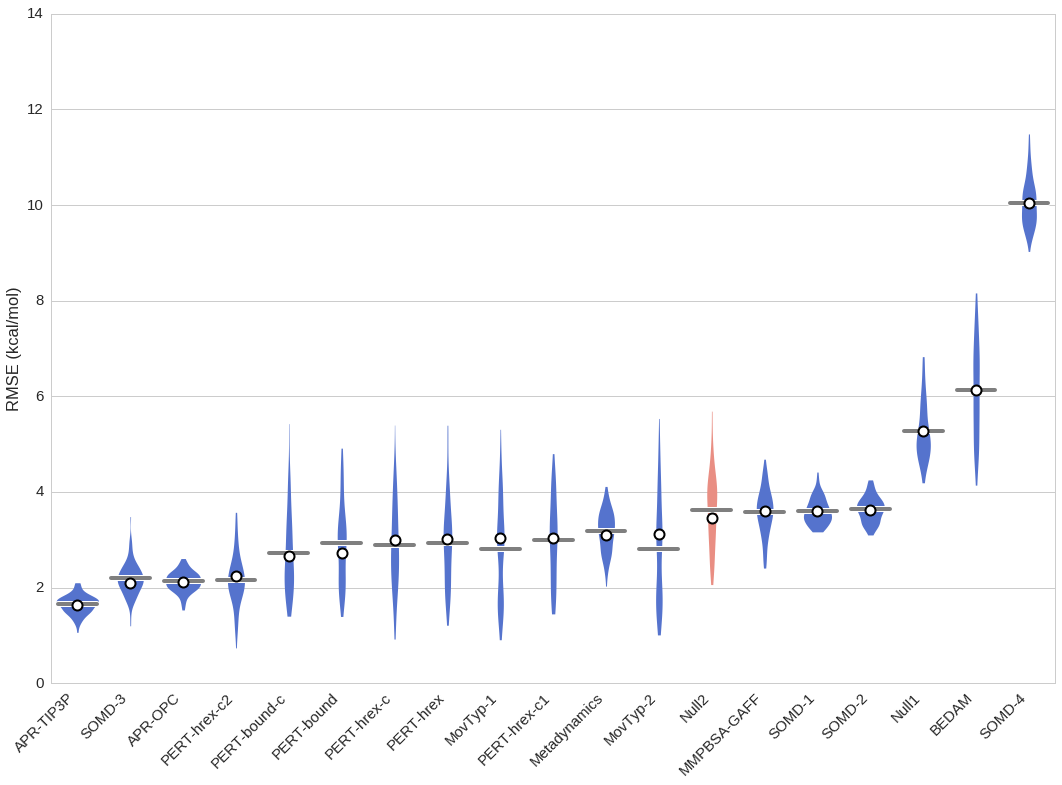

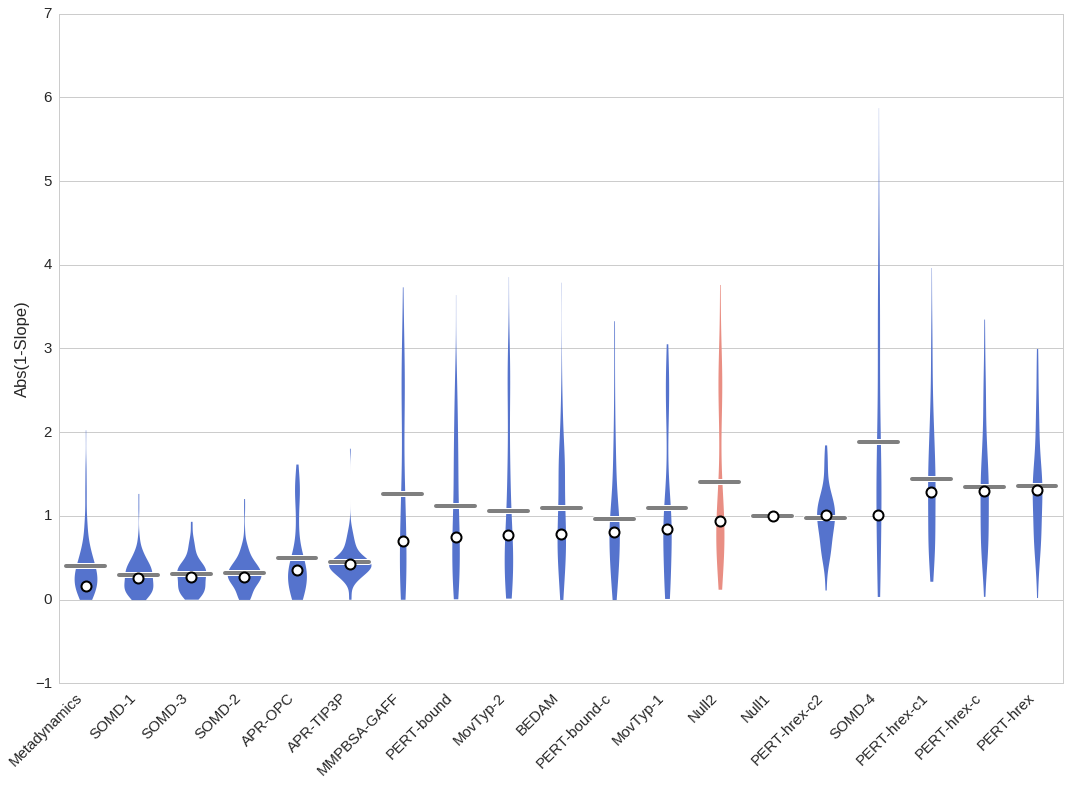

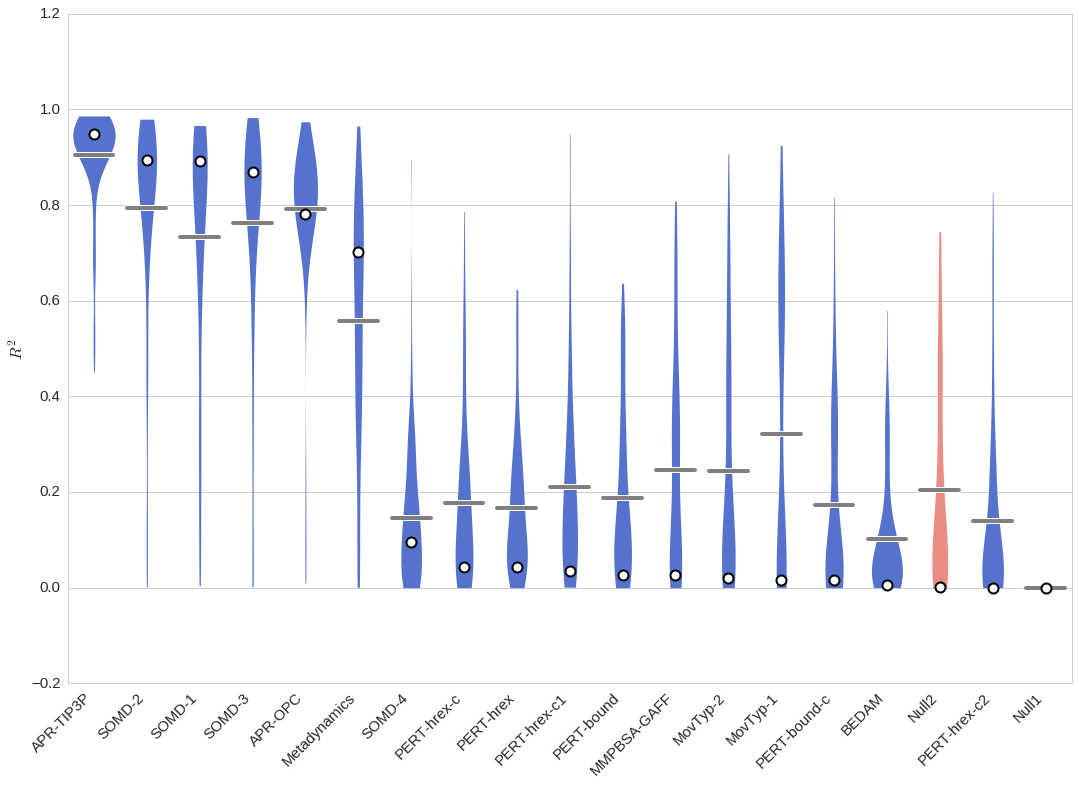

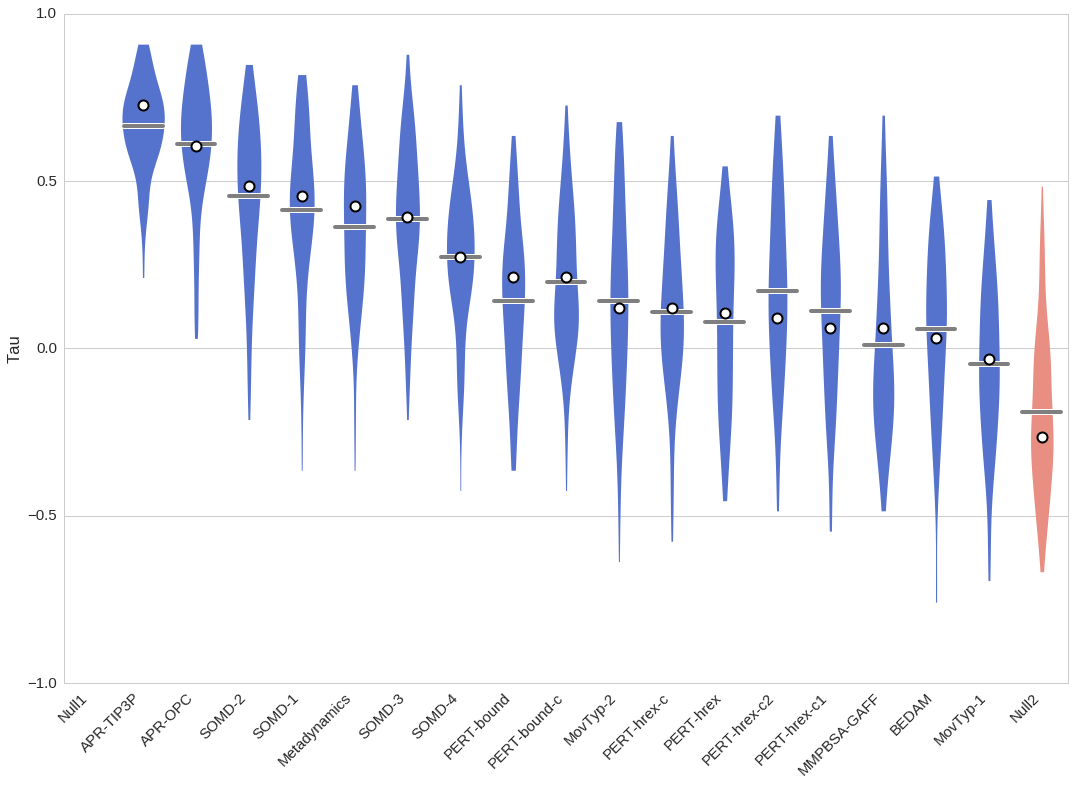

In [387]:
calculation_name = ["RMSE (kcal/mol)", "Abs(1-Slope)", "$R^{2}$", "Tau"]
calculation_index = [4, 0, 3, 7] # From Niel's MTmp


for i in calculation_index:

    Order = np.argsort(RawMs[0:Nc,i])
    if calculation_name[calculation_index.index(i)] == '$R^{2}$' or calculation_name[calculation_index.index(i)] == 'Tau':
        Order = Order[::-1]
    
    df = pd.DataFrame()
    df['AllMBoot'] = np.hstack(([AllMBoot[n,i] for n in Order]))
    df['Method'] = np.hstack(([np.repeat(CalcNames[n], len(AllMBoot[n,i]) ) for n in Order]))

    df2 = pd.DataFrame()
    df2['RawMs'] = [RawMs[n,i] for n in Order]
    df2['Method'] = [CalcNames[n] for n in Order]

    df3 = pd.DataFrame()
    df3['AllMVals'] = [AllMVals[n,i] for n in Order]
    df3['Method'] = [CalcNames[n] for n in Order]

    df4 = pd.DataFrame()
    df5 = pd.DataFrame()
    df4['Value'] = [AllMVals[n,i] for n in Order]
    df4['ValueMethod'] = ['AllMVals' for _ in Order] 
    df4['Method'] = [CalcNames[n] for n in Order]
    df5['Value'] = [RawMs[n,i] for n in Order]
    df5['ValueMethod'] = ['RawMs' for _ in Order] 
    df5['Method'] = [CalcNames[n] for n in Order]

    frames = [df4, df5]
    result = pd.concat(frames)

    labels = [CalcNames[n] for n in Order]
    palette = ['#4169e1' if i != 'Null' and i != 'Null2' else '#fa8072' for i in labels]
    fig, ax = plt.subplots(1, figsize=(18,12), dpi=300)
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set_style("whitegrid")
    sns.violinplot(x = 'Method', y = 'AllMBoot', data=df, inner=None, linewidth=0, palette=palette, cut = 0)
    # Seaborn is a bit limiting here; some properties don't get passed through to matplotlib.
    # sns.stripplot(x = 'Method', y = 'RawMs', data = df2, marker = 'o', color = 'w', zorder=21, edgecolor='black', s=10)
    for n in Order:
        ax.scatter(x = np.where(Order == n)[0], y = df2[df2['Method'] == CalcNames[n]]['RawMs'], s = 100, marker = 'o', color = 'w', edgecolor = 'k', linewidth = 2, zorder = 21)
    for n in Order:
        # This gets the column position because we are plotting using `Order` and the width of the line is 1/len(CalcNames).
        # We could shorten the line a little bit for better readability.
        ax.axhline(y = AllMVals[n, i], xmin = (np.where(Order == n)[0] / len(CalcNames)) + 0.007, xmax = np.where(Order == n)[0] / len(CalcNames) + 1/len(CalcNames) - 0.007, linewidth=2, c='k', lw = 4, zorder=20, alpha=0.5)
        # This adds a bit of a white background around the lines by plotting underneath a slightly larger line.
        ax.axhline(y = AllMVals[n, i], xmin = (np.where(Order == n)[0] / len(CalcNames)) + 0.007, xmax = np.where(Order == n)[0] / len(CalcNames) + 1/len(CalcNames) - 0.007, linewidth=2, c='w', lw = 6, zorder=19, alpha=1.0)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(calculation_name[calculation_index.index(i)])
    plt.xlabel('')



In [453]:
def compute_bootstrap(args):
    OAHOnly = False
    OAMeOnly = False
    CalcPairDiffs = False
    CorrectOA = False
    CorrectCB = False
    WithUncert = True 
    WithRep = True  

    ### Arguments: <Flags> <ExpType> <ExperimentFile> <CalculationFile1> [<CalculationFile2> ...]
    ### Note, files should have the same number of data points
    calcfiles=[]
    for arg in args:
      if arg == 'OAHOnly':
        OAHOnly = True
      if arg == 'OAMeOnly':
        OAMeOnly = True
      if arg == 'CalcPairDiffs':
        CalcPairDiffs = True
      if arg == 'CorrectOA':
        CorrectOA = True
      if arg == 'CorrectCB':
        CorrectCB = True
      if re.search(r'^(ka|dg|dh)$', arg):
        exptype = arg
      if re.search(r'\.txt$', arg):
        if re.search(r'Exp', arg):
          expfile = arg
        else:
          calcfiles.append(arg)


    ### Settings
    R = 0.0019872036
    T = 298.0
    BootCyc = 100
    MNames = ('Slope', 'Interc', 'R', 'R^2', 'RMSE', 'MSE', 'MUE', 'TAU')
    Nm = len(MNames)
    
    ### Load experimental file and place data in array
    print(expfile)
    with open(expfile, 'r') as expraw:
      explines = expraw.readlines()
    exp = []
    for line in explines:
      if not re.match(r'^\s*$', line):
        exp.append(line.rstrip().replace('\t', ' '))

    ### If "Only" flag, just do first six, or last six
    if OAHOnly:
      exp = exp[0:6]
    if OAMeOnly:
      exp = exp[6:12]
    if OAHOnly and OAMeOnly:
      print("OAHOnly=True and OAMeOnly=True! Not compatible")
      exit()
    N = len(exp)	# Number of data points
    Np = (N-1)*N/2  # Number of data pairs

    ### Are these binding constants or free energy (or enthalpy)? Convert.
    emean = np.zeros([N], np.float64)
    esem = np.zeros([N], np.float64)
    for i in range(len(exp)):
      cols = np.asarray(exp[i].split(), dtype=np.float64)
      if exptype == 'ka':       ### Assume binding constant. This could go wrong for very positive enthalpy
        dG = -R*T*np.log(cols)
        emean[i] = np.mean(dG)
        esem[i] = np.std(dG, ddof=1)/np.sqrt(len(dG))
      elif exptype == 'dg':
        emean[i] = cols[0]
        esem[i] = cols[1]
      elif exptype == 'dh': 
        emean[i] = np.mean(cols)/1000
        esem[i] = np.std(cols, ddof=1)/np.sqrt(len(cols))/1000
      else:
        print(exptype, "... is not a valid experimental type")

    ### Calculate Experimental Pairwise Differences
    if CalcPairDiffs:
      h = 0
      epmean = np.zeros([Np], np.float64)
      epsem = np.zeros([Np], np.float64)
      for i in range(len(exp)):
        for j in range(i+1, len(exp)):
          epmean[h] = emean[i] - emean[j]
          epsem[h] = np.sqrt( esem[i]**2 + esem[j]**2 )
          h += 1

    ### Read in Calculated data.  
    ### I should add a check to make sure number of data points is the same as experiment
    Nc = len(calcfiles)
    cmean = np.zeros([Nc,N], np.float64)
    csem = np.zeros([Nc,N], np.float64)
    if CalcPairDiffs:
      cdmean = np.zeros([Nc,Nd], np.float64)
      cdsem = np.zeros([Nc,Nd], np.float64)

    RawMs = np.zeros([Nc,Nm], np.float64)
    AllMBoot = np.zeros([Nc,Nm,BootCyc], np.float64)
    AllMVals = np.zeros([Nc,Nm], np.float64)
    AllMSEMs = np.zeros([Nc,Nm], np.float64)

    ### Print Metrics Column Headings
    #print "%30s " % ("Submission"),
    #for Name in MNames:
    #  print "%6s " % (Name),
    #print ""

    nc = 0
    for calcfile in calcfiles:
      calc = np.loadtxt(calcfile, np.float64)
      if OAHOnly:
        calc = calc[0:6]
      if OAMeOnly:
        calc = calc[6:12]
      for i in range(len(calc)):
        if np.isscalar(calc[i]) == True:      ### If scalar instead of array; ie, no SEM given.
          cmean[nc,i] = np.mean(calc[i])
          csem[nc,i] = 0.0
        else:                                 ### Assume Mean and SEM given
          cmean[nc,i] = calc[i,0]
          csem[nc,i] = calc[i,1]
        #print emean[i],esem[i],tmpcmean[i],tmpcsem[i]


      ### Correct data set with MSE
      if CorrectOA:
        cmean[nc,0:6] = cmean[nc,0:6] - (np.mean(cmean[nc,0:6]) - np.mean(emean[0:6]))
        if len(calc) == 12:
          cmean[nc,6:12] = cmean[nc,6:12]- (np.mean(cmean[nc,6:12]) - np.mean(emean[6:12]))
      if CorrectCB:
        cmean[nc,0:10] = cmean[nc,0:10] - (np.mean(cmean[nc,0:10]) - np.mean(emean[0:10]))

      if CalcPairDiffs:
        h = 0
        for i in range(len(calc)):
          for j in range(i+1, len(calc)):
            cpmean[nc,h] = cmean[nc,i] - cmean[nc,j]
            cpsem[nc,h] = np.sqrt( csem[nc,i]**2 + csem[nc,j]**2 )
            #print cpmean[nc,h]#,cdsem[nc,h]
            h += 1

      RawMs[nc] = geterrormetrics(emean, cmean[nc])
      AllMVals[nc],AllMSEMs[nc],AllMBoot[nc] = bootstrap(emean, esem, cmean[nc], csem[nc])
      #print "%30s " % (calcfile),
      #for m in range(Nm):
      #  print "%6.2f " % (RawMs[nc,m]),
      #print ""

      nc += 1
    
    CalcNames=[]
    for name in calcfiles:
      cols = name.split('.')
      CalcNames.append(cols[0])

    
    return(RawMs, AllMBoot, AllMVals, CalcNames, Nc)

In [474]:
def plot_summary(Nc, RawMs, AllMBoot, AllMVals, CalcNames, absolute, relative, prefix):
    
    if absolute:
        calculation_name = ["RMSE (kcal/mol)", "Abs(1-Slope)", "$R^{2}$", "Tau"]
    if relative:
        calculation_name = ["RMSE_c (kcal/mol)", "Abs(1-Slope)_c", "$R^{2}$_c", "Tau_c"]
    calculation_index = [4, 0, 3, 7] # From Niel's MTmp
    

    for i in calculation_index:

        Order = np.argsort(RawMs[0:Nc,i])
        if calculation_name[calculation_index.index(i)] == '$R^{2}$' or calculation_name[calculation_index.index(i)] == 'Tau':
            Order = np.argsort(RawMs[0:Nc,i])[::-1]
        
        CalcNames=['TI/BAR' if CalcNames[n] == 'TIxBar' else CalcNames[n] for n in Order] 

        df = pd.DataFrame()
        df['AllMBoot'] = np.hstack(([AllMBoot[n,i] for n in Order]))
        df['Method'] = np.hstack(([np.repeat(CalcNames[n], len(AllMBoot[n,i]) ) for n in Order]))

        df2 = pd.DataFrame()
        df2['RawMs'] = [RawMs[n,i] for n in Order]
        df2['Method'] = [CalcNames[n] for n in Order]

        df3 = pd.DataFrame()
        df3['AllMVals'] = [AllMVals[n,i] for n in Order]
        df3['Method'] = [CalcNames[n] for n in Order]

        df4 = pd.DataFrame()
        df5 = pd.DataFrame()
        df4['Value'] = [AllMVals[n,i] for n in Order]
        df4['ValueMethod'] = ['AllMVals' for _ in Order] 
        df4['Method'] = [CalcNames[n] for n in Order]
        df5['Value'] = [RawMs[n,i] for n in Order]
        df5['ValueMethod'] = ['RawMs' for _ in Order] 
        df5['Method'] = [CalcNames[n] for n in Order]

        frames = [df4, df5]
        result = pd.concat(frames)

        labels = [CalcNames[n] for n in Order]
        palette = ['#4169e1' if i != 'Null1' and i != 'Null2' else '#fa8072' for i in labels]
        
        sns.set_context("paper", font_scale=3, rc={"lines.linewidth": 2.5})
        fig, ax = plt.subplots(1, figsize=(18,12), dpi=300)
        g = sns.violinplot(x = 'Method', y = 'AllMBoot', data=df, inner=None, linewidth=0, palette=palette, cut = 0)
        g.set_xticks([i + 0.5 for i in range(len(Order))])
        for n in Order:
            ax.scatter(x = np.where(Order == n)[0], y = df2[df2['Method'] == CalcNames[n]]['RawMs'], s = 100, marker = 'o', color = 'w', edgecolor = 'k', linewidth = 2, zorder = 21)
        for n in Order:
            # This gets the column position because we are plotting using `Order` and the width of the line is 1/len(CalcNames).
            # We could shorten the line a little bit for better readability.
            ax.axhline(y = AllMVals[n, i], xmin = (np.where(Order == n)[0] / len(Order)) + 0.007, xmax = np.where(Order == n)[0] / len(Order) + 1/len(Order) - 0.007, linewidth=2, c='k', lw = 4, zorder=20, alpha=0.5)
            # This adds a bit of a white background around the lines by plotting underneath a slightly larger line.
            ax.axhline(y = AllMVals[n, i], xmin = (np.where(Order == n)[0] / len(Order)) + 0.007, xmax = np.where(Order == n)[0] / len(Order) + 1/len(Order) - 0.007, linewidth=2, c='w', lw = 6, zorder=19, alpha=1.0)
                        
        plt.xticks(rotation=45, ha='right')
        plt.ylabel(calculation_name[calculation_index.index(i)])
        plt.xlabel('')
        # Let's limit slope and R^2 for better aesthetics.
        if calculation_name[calculation_index.index(i)] == '$R^{2}$' or calculation_name[calculation_index.index(i)] == '$R^{2}$_c':
            plt.ylim([-0.05, 1])
        # Fix the lower limit only for the Abs(1-slope) aesthetic.
        if calculation_name[calculation_index.index(i)] == 'Abs(1-Slope)' or calculation_name[calculation_index.index(i)] == 'Abs(1-Slope)_c':
            plt.ylim(-0.5, ax.get_ylim()[1])
        # Because RMSE has units and we don't want them in the title.
        if calculation_name[calculation_index.index(i)] != 'RMSE (kcal/mol)' and calculation_name[calculation_index.index(i)] != 'RMSE_c (kcal/mol)':
            plt.title(prefix + ', ' + calculation_name[calculation_index.index(i)])
        elif absolute:
            plt.title(prefix + ', ' + 'RMSE')
        elif relative:
            plt.title(prefix + ', ' + 'RMSE_c')

../Exp/OASaltDep.txt


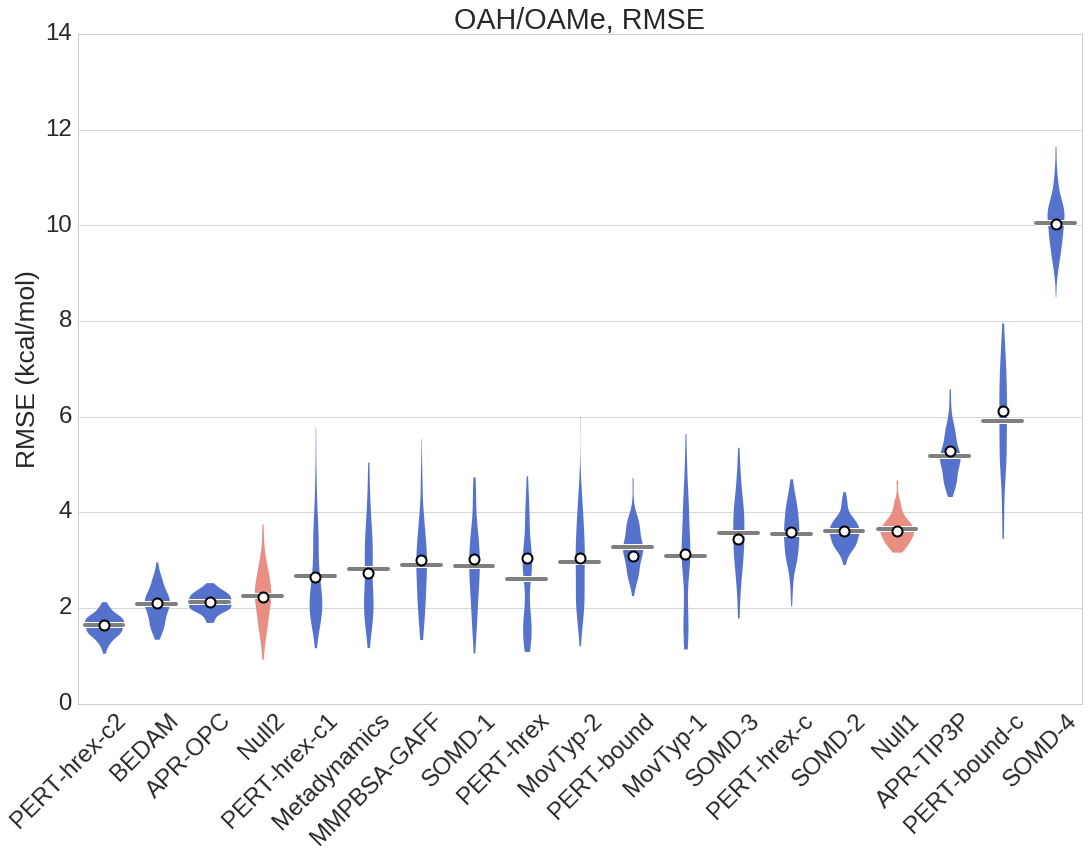

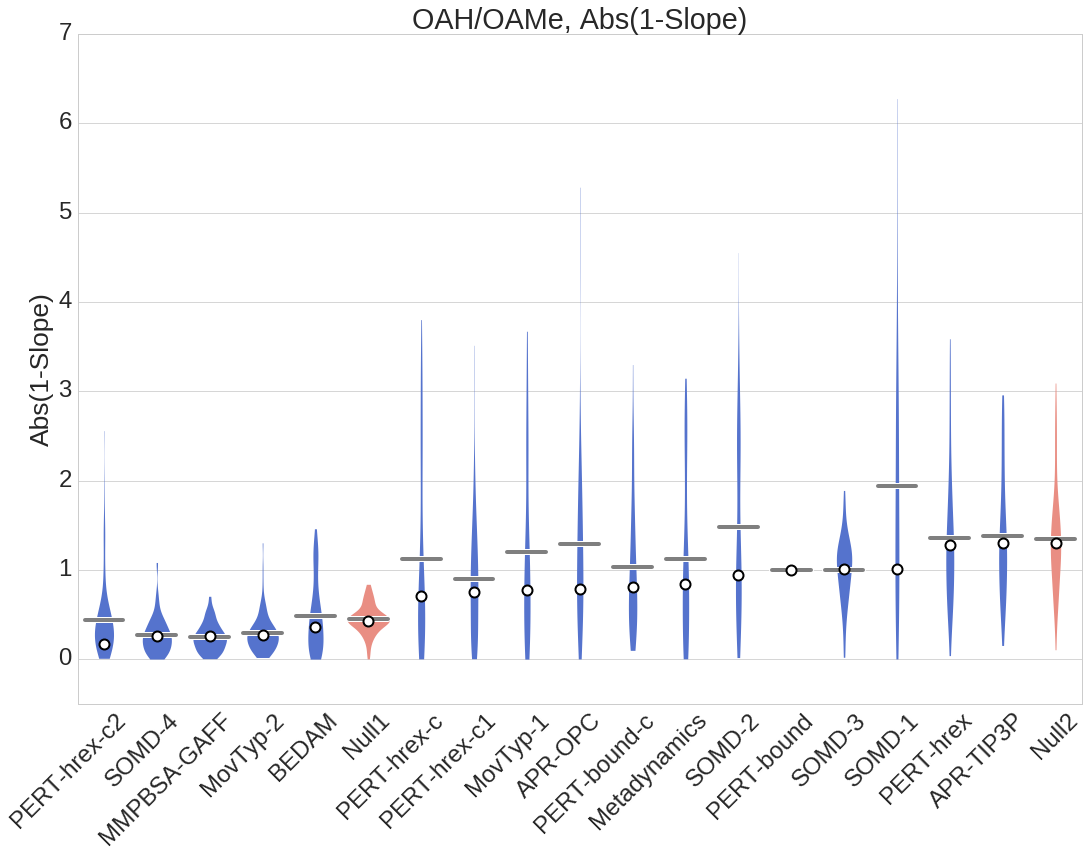

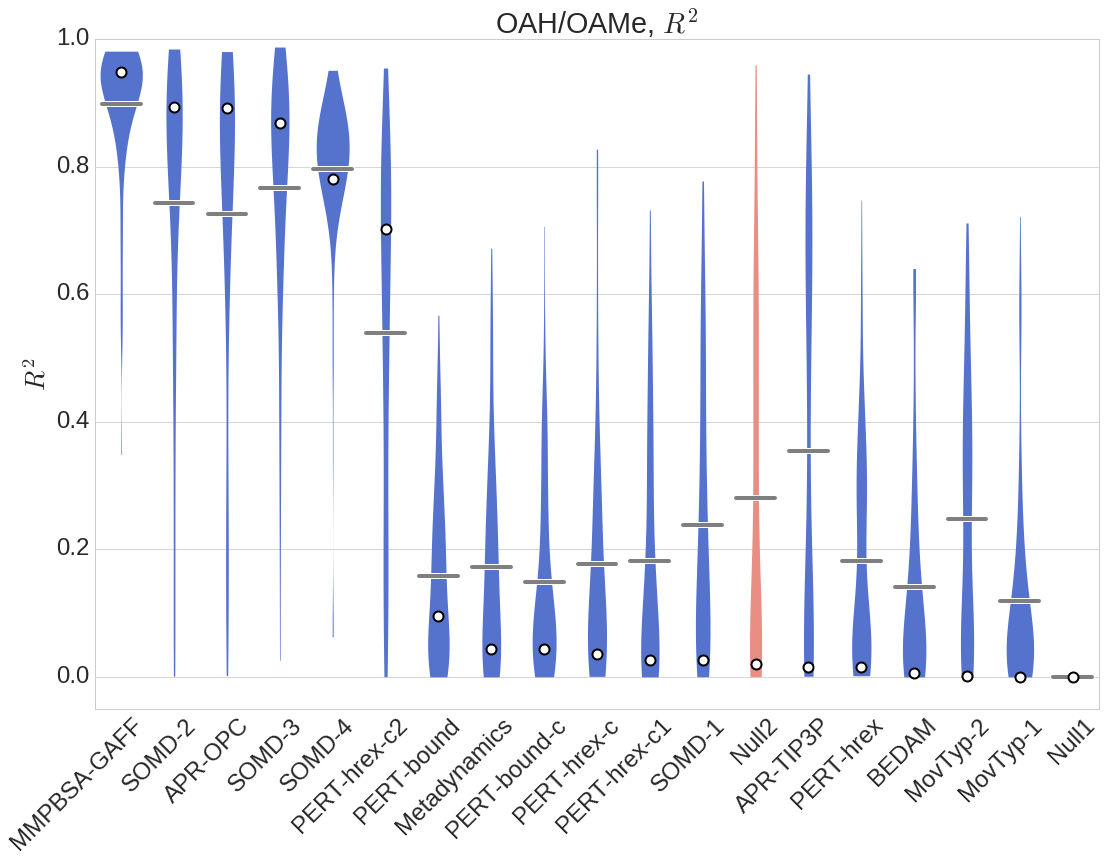

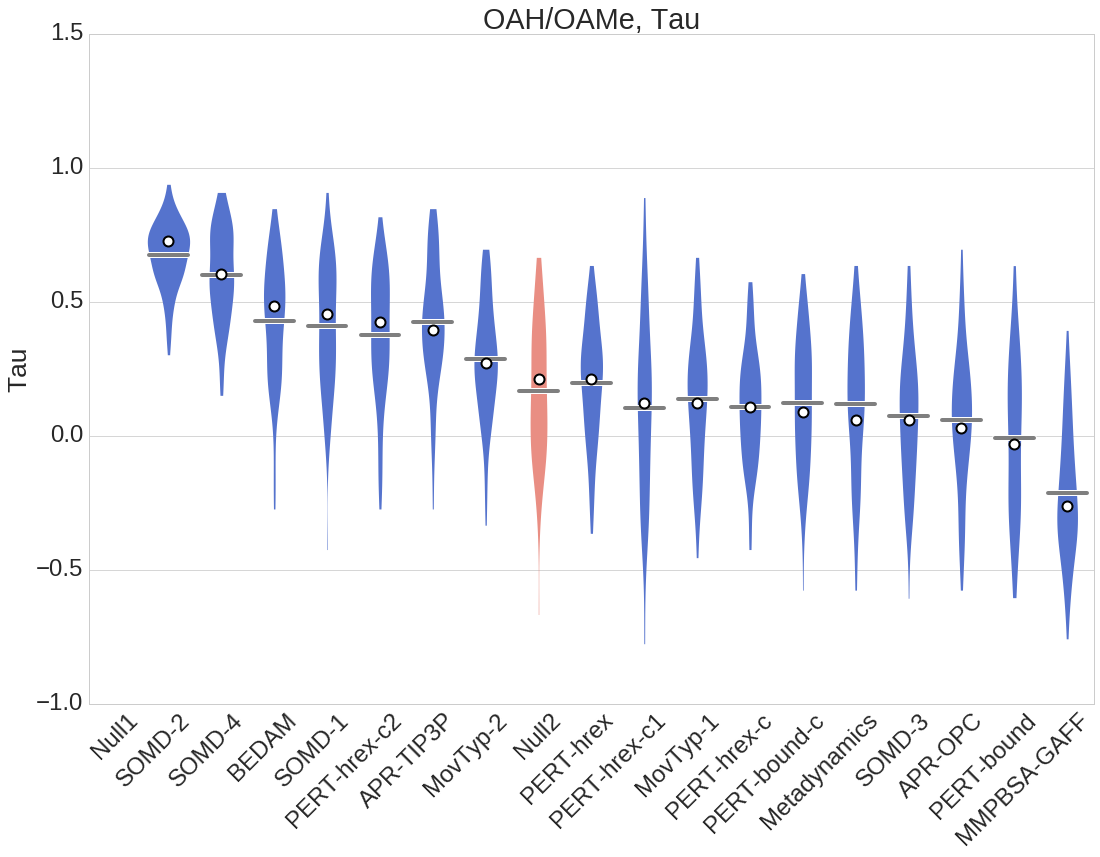

In [475]:
#SaltDep-Abs
os.chdir('/run/media/dslochower/b52b33d4-b9b5-4e58-a87e-d8751720538c/2016-Research/Nonequilibrium/torsion-individual/Boot8/Calc-OA')
string = 'ka ../Exp/OASaltDep.txt Null1.txt Null2.txt APR-OPC.txt APR-TIP3P.txt BEDAM.txt Metadynamics.txt MMPBSA-GAFF.txt MovTyp-1.txt MovTyp-2.txt PERT-bound-c.txt PERT-bound.txt PERT-hrex-c1.txt PERT-hrex-c2.txt PERT-hrex-c.txt PERT-hrex.txt SOMD-1.txt SOMD-2.txt SOMD-3.txt SOMD-4.txt'
args = string.split()
RawMs, AllMBoot, AllMVals, CalcNames, Nc = compute_bootstrap(args)
plot_summary(Nc, RawMs, AllMBoot, AllMVals, CalcNames, absolute=True, relative=False, prefix='OAH/OAMe')


../Exp/OASaltDep.txt


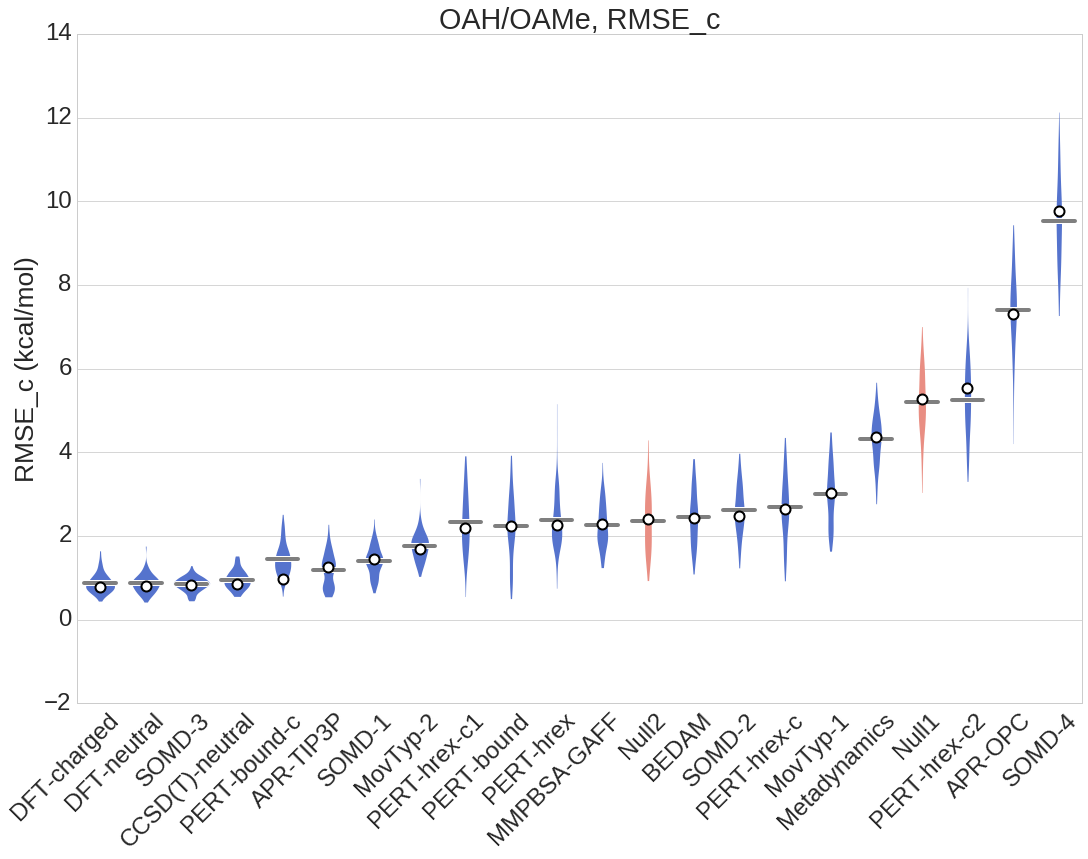

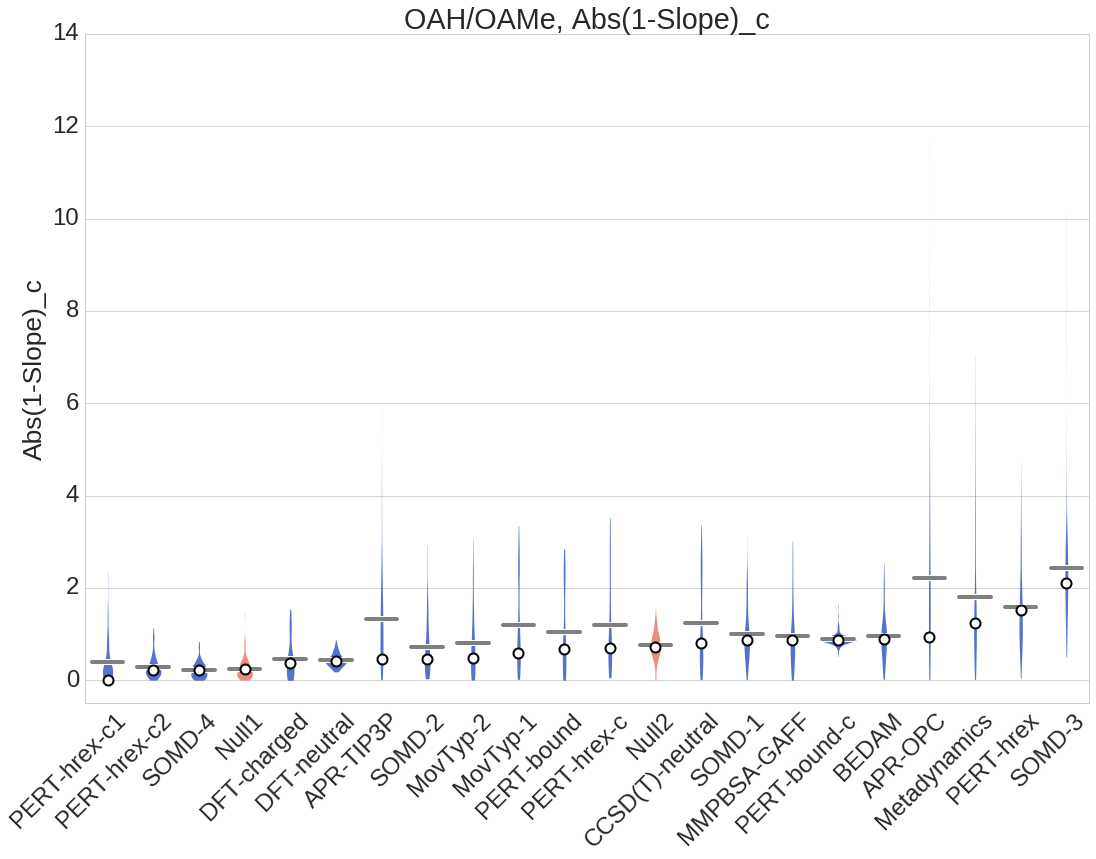

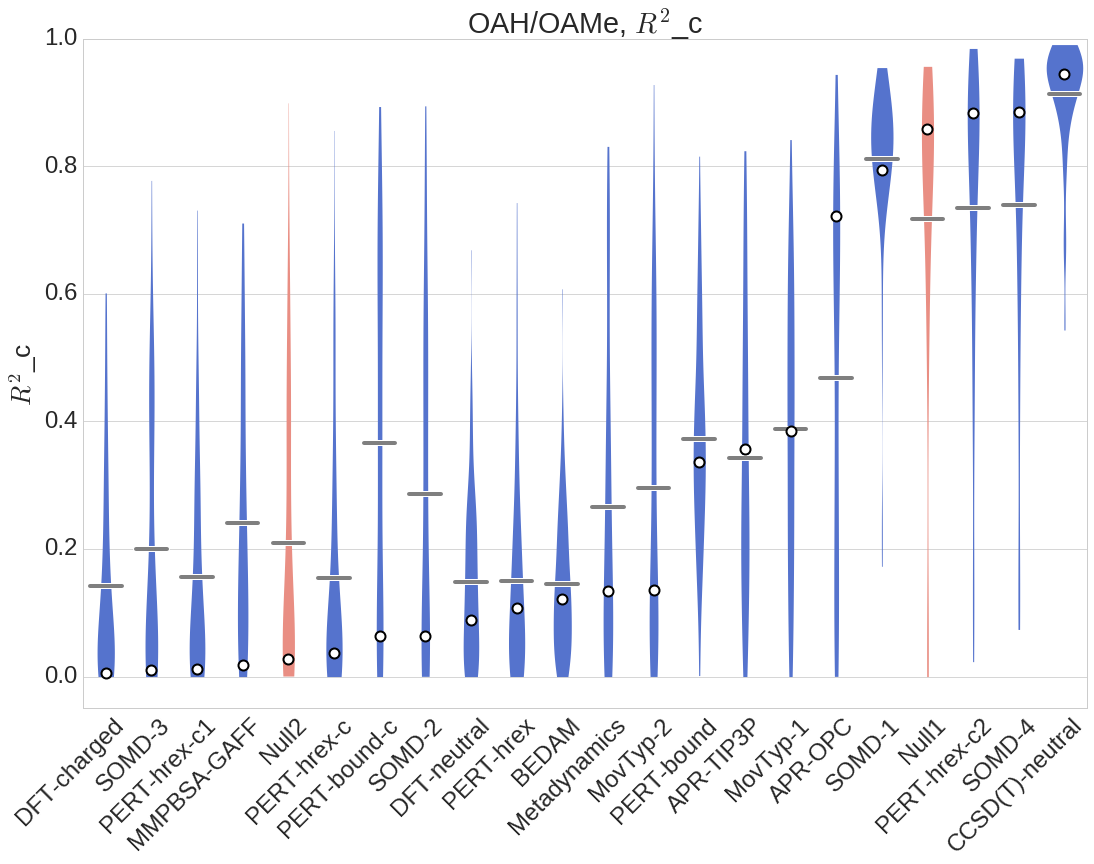

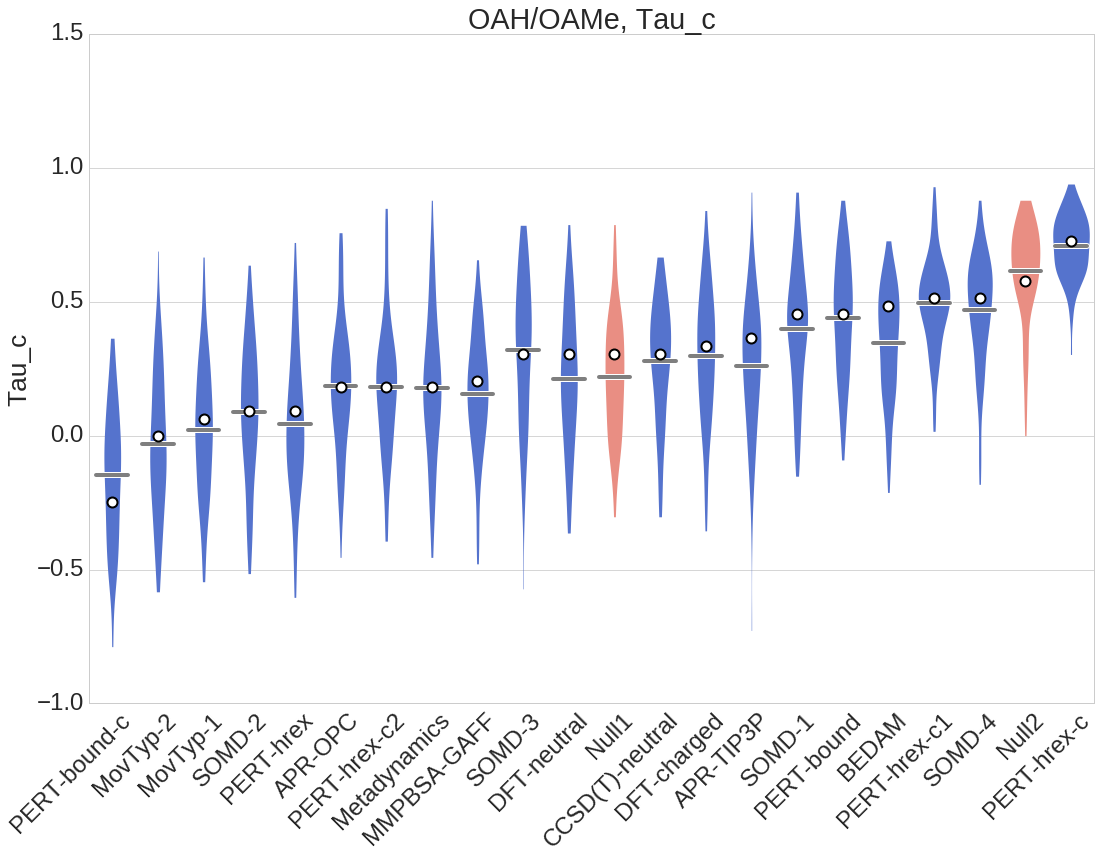

In [476]:
#SaltDep-RelCor
os.chdir('/run/media/dslochower/b52b33d4-b9b5-4e58-a87e-d8751720538c/2016-Research/Nonequilibrium/torsion-individual/Boot8/Calc-OA')
string = 'CorrectOA ka ../Exp/OASaltDep.txt Null1.txt Null2.txt APR-OPC.txt APR-TIP3P.txt BEDAM.txt CCSD(T)-neutral.txt DFT-charged.txt DFT-neutral.txt Metadynamics.txt MMPBSA-GAFF.txt MovTyp-1.txt MovTyp-2.txt PERT-bound-c.txt PERT-bound.txt PERT-hrex-c1.txt PERT-hrex-c2.txt PERT-hrex-c.txt PERT-hrex.txt SOMD-1.txt SOMD-2.txt SOMD-3.txt SOMD-4.txt'
args = string.split()
RawMs, AllMBoot, AllMVals, CalcNames, Nc = compute_bootstrap(args)
plot_summary(Nc, RawMs, AllMBoot, AllMVals, CalcNames, absolute=False, relative=True, prefix='OAH/OAMe')

../Exp/CBClip.txt


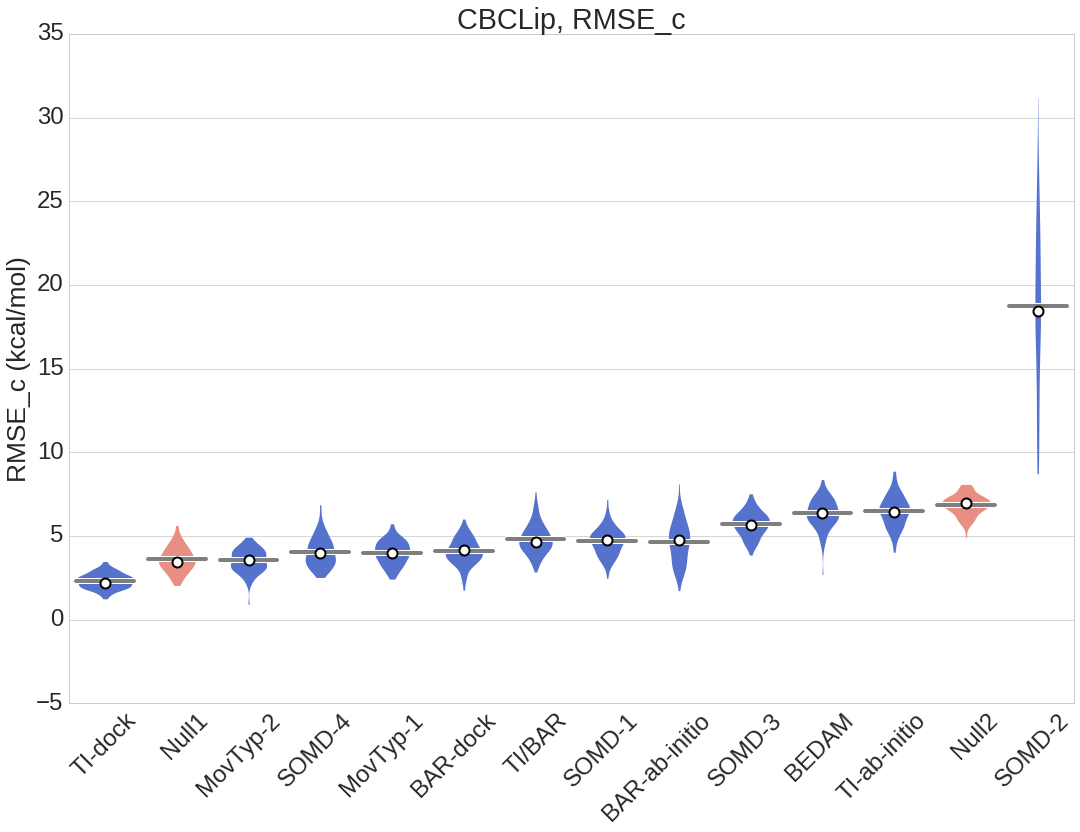

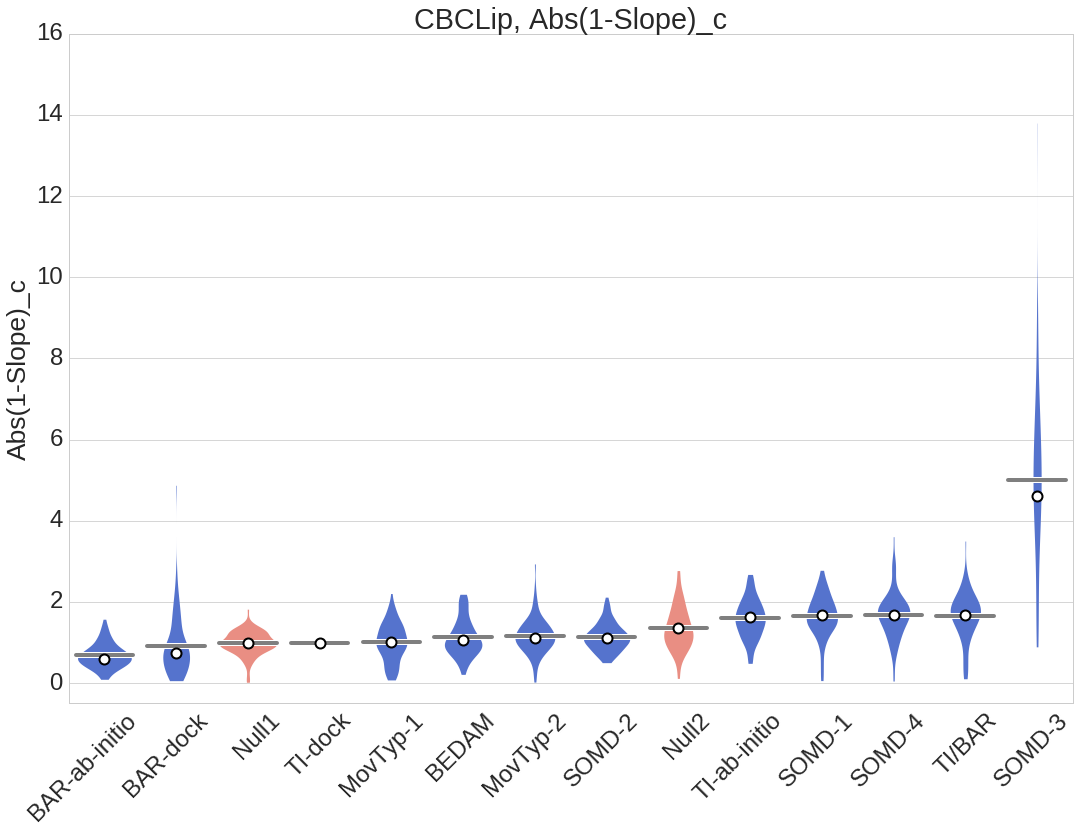

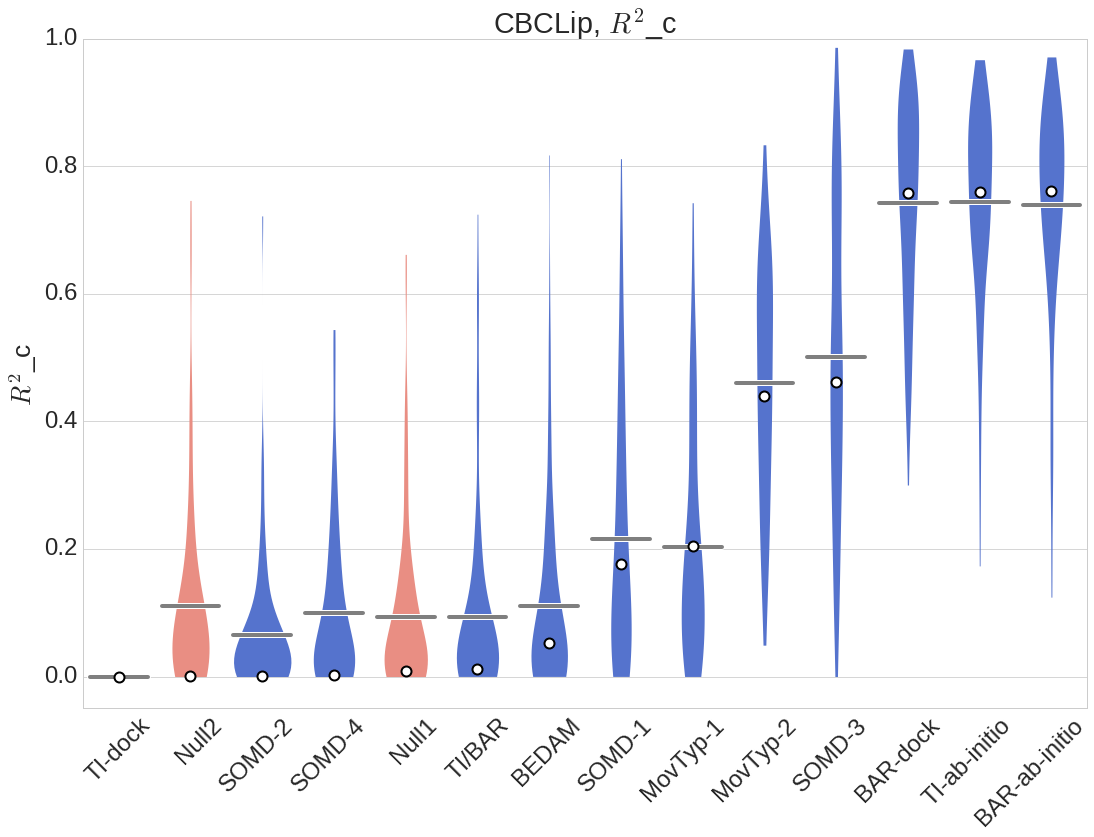

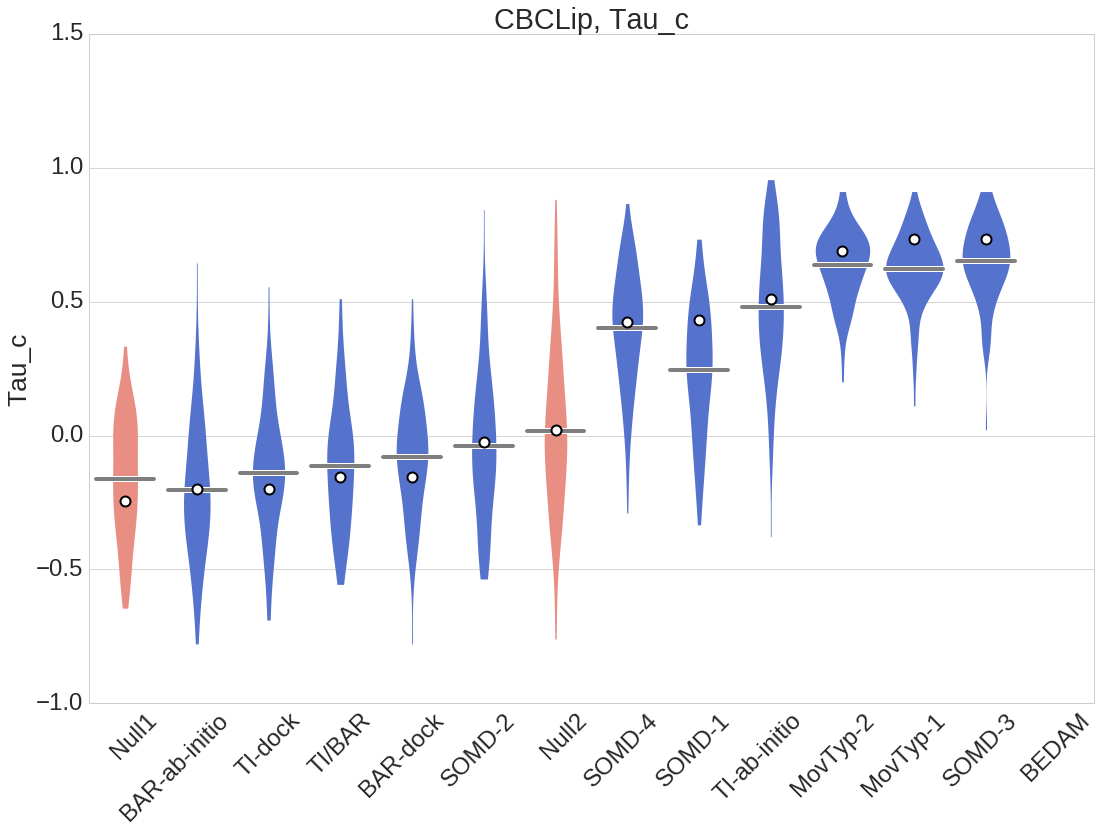

In [477]:
#CBClip-Abs
os.chdir('/run/media/dslochower/b52b33d4-b9b5-4e58-a87e-d8751720538c/2016-Research/Nonequilibrium/torsion-individual/Boot8/Calc-CB')
string = 'ka ../Exp/CBClip.txt Null1.txt Null2.txt BAR-ab-initio.txt BAR-dock.txt BEDAM.txt MovTyp-1.txt MovTyp-2.txt SOMD-1.txt SOMD-2.txt SOMD-3.txt SOMD-4.txt TI-ab-initio.txt TI-dock.txt TIxBar.txt'
args = string.split()
RawMs, AllMBoot, AllMVals, CalcNames, Nc = compute_bootstrap(args)
plot_summary(Nc, RawMs, AllMBoot, AllMVals, CalcNames, absolute=False, relative=True, prefix='CBCLip')
